In [1]:
import src.dataPipeline as dataPipeline
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
# Evaluating the model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,r2_score ,make_scorer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

importlib.reload(dataPipeline)


C:\Users\wartm\Documents\FHNW\immo_challenge\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'src.dataPipeline' from 'C:\\Users\\wartm\\Documents\\FHNW\\immo_challenge\\src\\dataPipeline.py'>

In [2]:
def calculate_metrics(X_train, y_test, y_pred):
    n = len(y_test)  # Number of observations
    k = X_train.shape[1]  # Number of predictors
    r2 = round(r2_score(y_test, y_pred), 4)
    R2_adjusted = round(1 - (1 - r2) * (n - 1) / (n - k - 1), 4)
    mape = round(mean_absolute_percentage_error(y_test, y_pred) * 100, 4)
    return r2, R2_adjusted, mape

In [3]:
def manual_cv_score(X, y, cv, model):
    fold_train_mapes = []
    fold_test_mapes = []

    # Manual CV loop
    for train_idx, test_idx in cv.split(X):
        # Split the data for this fold
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model
        model.fit(X_tr, y_tr)

        # Predict on training fold
        y_tr_pred = model.predict(X_tr)
        fold_train_mapes.append(mean_absolute_percentage_error(y_tr, y_tr_pred))

        # Predict on test fold
        y_te_pred = model.predict(X_te)
        fold_test_mapes.append(mean_absolute_percentage_error(y_te, y_te_pred))

    # Calculate mean & std for train/test MAPE across folds
    train_mape_mean = np.mean(fold_train_mapes) * 100
    train_mape_std  = np.std(fold_train_mapes)  * 100

    test_mape_mean  = np.mean(fold_test_mapes)  * 100
    test_mape_std   = np.std(fold_test_mapes)   * 100

    return train_mape_mean, train_mape_std, test_mape_mean, test_mape_std

In [4]:
dp = dataPipeline.DataPipeline()
df = dp.runPipeline(
    filePath="../data/immo_data_202208_v2.csv",
    imputer=None,
    normalizeAndStandardize= False,
    basic_house_imputer = False,
    get_dummies = False
)

C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:44: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in 

In [5]:
#show all columns
pd.set_option('display.max_columns', None)

In [6]:
#drop column Availability
df = df.drop(columns=["Availability"])

In [7]:
df.head()

,Floor,detail_responsive#surface_usable,Floor_space_merged,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,PopulationDensityL,PopulationDensityM,PopulationDensityS,RiversAndLakesL,RiversAndLakesM,RiversAndLakesS,WorkplaceDensityL,WorkplaceDensityM,WorkplaceDensityS,distanceToTrainStation,gde_area_agriculture_percentage,gde_area_forest_percentage,gde_area_nonproductive_percentage,gde_area_settlement_percentage,gde_average_house_hold,gde_empty_apartments,gde_foreigners_percentage,gde_new_homes_per_1000,gde_politics_bdp,gde_politics_cvp,gde_politics_evp,gde_politics_fdp,gde_politics_glp,gde_politics_gps,gde_politics_pda,gde_politics_rights,gde_politics_sp,gde_politics_svp,gde_pop_per_km2,gde_population,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,price_cleaned,Space extracted,type_unified,Plot_area_unified,No. of rooms:,Last refurbishment:,Year built:,Number of floors:,region_group
0,4.0,NaN,NaN,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1150000.0,100.0,penthouse,NaN,5.0,NaN,NaN,NaN,45.0
1,NaN,NaN,242.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1420000.0,156.0,terrace-house,222.0,5.0,NaN,NaN,NaN,45.0
2,2.0,NaN,NaN,0.163362,0.095877,0.001911,0.0,0.0,0.0,0.334957,0.381257,0.297575,0.325887,0.393783,0.635194,0.154274,0.188229,0.000000,0.172646,0.163850,0.165830,0.909587,11.354420,32.197891,7.137064,49.310624,2.01,2.023799,21.358623,3.814582,3.633134,5.324421,3.782202,18.089552,7.899807,8.851305,NaN,0.735032,26.515854,22.662290,1704.700162,21036.0,10149.0,3.549010,6.05,37.0,3092.0,30364.0,33493.0,720000.0,93.0,penthouse,NaN,5.0,NaN,NaN,NaN,45.0
3,NaN,NaN,257.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1430000.0,154.0,detached-house,370.0,5.0,NaN,NaN,NaN,45.0
4,0.0,NaN,NaN,0.333865,0.279276,0.145835,0.0,0.0,0.0,0.133498,0.132933,0.235917,0.190986,0.136984,0.204549,0.109586,0.141473,0.091805,0.046950,0.038008,0.055509,1.460245,33.137090,49.705635,1.177460,15.979815,2.28,0.691563,15.901990,1.160862,5.217740,5.728026,5.006679,19.158429,6.502805,7.477959,NaN,0.892332,20.459524,27.590168,511.008403,6081.0,2638.0,1.708126,6.30,65.0,349.0,941.0,1355.0,995000.0,142.0,flat,NaN,5.0,NaN,NaN,NaN,45.0


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20786 entries, 0 to 22480
Columns: 107 entries, Floor to region_group_49
dtypes: float64(106), object(1)
memory usage: 17.1+ MB


In [87]:
df["type_unified"] = df["type_unified"].astype('category')

In [88]:
df.head()

,Floor,detail_responsive#surface_usable,Floor_space_merged,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,PopulationDensityL,PopulationDensityM,PopulationDensityS,RiversAndLakesL,RiversAndLakesM,RiversAndLakesS,WorkplaceDensityL,WorkplaceDensityM,WorkplaceDensityS,distanceToTrainStation,gde_area_agriculture_percentage,gde_area_forest_percentage,gde_area_nonproductive_percentage,gde_area_settlement_percentage,gde_average_house_hold,gde_empty_apartments,gde_foreigners_percentage,gde_new_homes_per_1000,gde_politics_bdp,gde_politics_cvp,gde_politics_evp,gde_politics_fdp,gde_politics_glp,gde_politics_gps,gde_politics_pda,gde_politics_rights,gde_politics_sp,gde_politics_svp,gde_pop_per_km2,gde_population,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,price_cleaned,Space extracted,type_unified,Plot_area_unified,No. of rooms:,Last refurbishment:,Year built:,Number of floors:,region_group_0,region_group_1,region_group_2,region_group_3,region_group_4,region_group_5,region_group_6,region_group_7,region_group_8,region_group_9,region_group_10,region_group_11,region_group_12,region_group_13,region_group_14,region_group_15,region_group_16,region_group_17,region_group_18,region_group_19,region_group_20,region_group_21,region_group_22,region_group_23,region_group_24,region_group_25,region_group_26,region_group_27,region_group_28,region_group_29,region_group_30,region_group_31,region_group_32,region_group_33,region_group_34,region_group_35,region_group_36,region_group_37,region_group_38,region_group_39,region_group_40,region_group_41,region_group_42,region_group_43,region_group_44,region_group_45,region_group_46,region_group_47,region_group_48,region_group_49
0,4.0,NaN,NaN,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1150000.0,100.0,penthouse,NaN,5.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,242.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1420000.0,156.0,terrace-house,222.0,5.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,NaN,NaN,0.163362,0.095877,0.001911,0.0,0.0,0.0,0.334957,0.381257,0.297575,0.325887,0.393783,0.635194,0.154274,0.188229,0.000000,0.172646,0.163850,0.165830,0.909587,11.354420,32.197891,7.137064,49.310624,2.01,2.023799,21.358623,3.814582,3.633134,5.324421,3.782202,18.089552,7.899807,8.851305,NaN,0.735032,26.515854,22.662290,1704.700162,21036.0,10149.0,3.549010,6.05,37.0,3092.0,30364.0,33493.0,720000.0,93.0,penthouse,NaN,5.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,257.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.58937

In [89]:
cat_col = ["type_unified"] + [f"region_group_{i}" for i in range(50)]

house_type = ["type_unified"]
num_col = [col for col in df.columns if col not in cat_col + ["price_cleaned"]]

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('cat', categorical_transformer, house_type)
    ]
)

# Random Forest baseline model

In [90]:
rf_baseline = RandomForestRegressor(
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None
)

In [91]:
# Create and combine preprocessing and modeling in a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_baseline)
])

# Separate target and features
X = df.drop(columns=["price_cleaned"])
y = df["price_cleaned"]
y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Floor',
                                                   'detail_responsive#surface_usable',
                                                   'Floor_space_merged',
                                                   'ForestDensityL',
                                                   'ForestDensityM',
                                                   'ForestDensityS',
                                                   'NoisePollutionRailwayL',
                                                   'NoisePollutionRailwayM',
                                                   'NoisePollutionRailwayS',
                                                   'NoisePollutionRo...
                                                   'gde_area_forest_percentage',
                                                   'gde_area_nonproductive_percentage',
                                                   'gde_area_settlement_percentage',
                                                   'gde_average_house_hold',
                                                   'gde_empty_apartments',
                                                   'gde_foreigners_percentage',
                                                   'gde_new_homes_per_1000', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type_unified'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [92]:
#caluclate mape on train data
y_pred = pipeline.predict(X_train)
r2, R2_adjusted, mape = calculate_metrics(X_train, np.exp(y_train) , np.exp(y_pred))
print(f"R2 {r2},Adjusted R^2:{R2_adjusted}, MAPE:{mape}%")

R2 0.9412,Adjusted R^2:0.9408, MAPE:8.308%


In [93]:
#caluclate mape on test data
y_pred = pipeline.predict(X_test)
r2, R2_adjusted, mape=calculate_metrics(X_train, np.exp(y_test), np.exp(y_pred))
print(f"R2 {r2},Adjusted R^2:{R2_adjusted}, MAPE:{mape}%")

R2 0.7101,Adjusted R^2:0.7025, MAPE:24.943%


# Hyperparameter tuning: Estimators

In [17]:
# Suppose we have these
estimators = [10, 20, 50, 70, 100, 200]
cv = KFold(n_splits=5, shuffle=True, random_state=42)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)


train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []

In [18]:
for estimator in tqdm(estimators):
    rf_estimator = RandomForestRegressor(
        n_estimators=estimator,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1
    )
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # For storing MAPE per fold
    fold_train_mapes = []
    fold_test_mapes = []

    # Manual CV loop
    for train_idx, test_idx in cv.split(X_train_preprocessed):
        X_tr, X_te = X_train_preprocessed.iloc[train_idx], X_train_preprocessed.iloc[test_idx]
        y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

        pipeline.fit(X_tr, y_tr)

        # Predict on training fold
        y_tr_pred = pipeline.predict(X_tr)
        fold_train_mapes.append(mean_absolute_percentage_error(np.exp(y_tr), np.exp(y_tr_pred)))

        # Predict on test fold
        y_te_pred = pipeline.predict(X_te)
        fold_test_mapes.append(mean_absolute_percentage_error(np.exp(y_te), np.exp(y_te_pred)))


    # Average across folds
    train_mape_mean = np.mean(fold_train_mapes) * 100
    train_mape_std = np.std(fold_train_mapes) * 100

    test_mape_mean = np.mean(fold_test_mapes) * 100
    test_mape_std = np.std(fold_test_mapes) * 100

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    print(
        f"Estimator: {estimator}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )

 17%|█▋        | 1/6 [00:13<01:09, 13.84s/it]

Estimator: 10, Train MAPE: 9.89% (±0.16), Test MAPE: 27.36% (±2.12)


 33%|███▎      | 2/6 [00:37<01:17, 19.46s/it]

Estimator: 20, Train MAPE: 9.16% (±0.11), Test MAPE: 26.59% (±2.67)


 50%|█████     | 3/6 [01:39<01:56, 38.84s/it]

Estimator: 50, Train MAPE: 8.61% (±0.07), Test MAPE: 25.91% (±2.46)


 67%|██████▋   | 4/6 [03:05<01:55, 57.67s/it]

Estimator: 70, Train MAPE: 8.52% (±0.05), Test MAPE: 25.80% (±2.34)


 83%|████████▎ | 5/6 [05:12<01:22, 82.43s/it]

Estimator: 100, Train MAPE: 8.43% (±0.05), Test MAPE: 25.79% (±2.40)


100%|██████████| 6/6 [09:18<00:00, 93.15s/it] 

Estimator: 200, Train MAPE: 8.35% (±0.05), Test MAPE: 25.66% (±2.36)


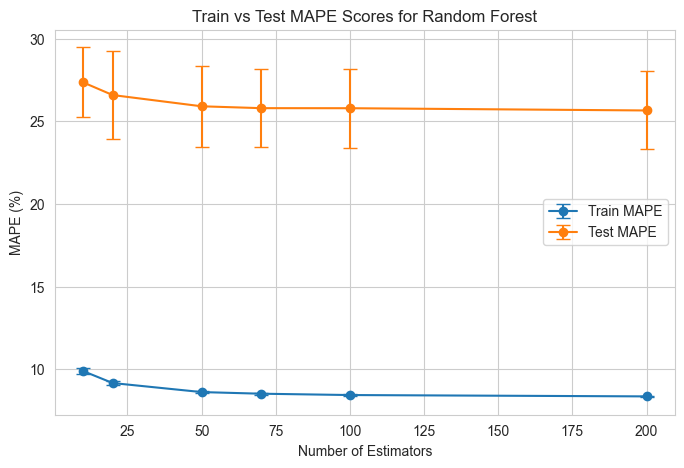

In [19]:
# Plot the MAPE scores
plt.figure(figsize=(8, 5))
plt.errorbar(estimators, train_mape_scores_mean, yerr=train_mape_scores_std, label='Train MAPE', marker='o', capsize=5)
plt.errorbar(estimators, test_mape_scores_mean, yerr=test_mape_scores_std, label='Test MAPE', marker='o', capsize=5)
plt.xlabel('Number of Estimators')
plt.ylabel('MAPE (%)')
plt.title('Train vs Test MAPE Scores for Random Forest')
plt.legend()
plt.grid(True)
plt.show()



# Hyperparameter tuning: Max Depth

In [ ]:
# Suppose we have these
depths = [7, 10, 15, 20, 25, 30, 35]
cv = KFold(n_splits=5, shuffle=True, random_state=42)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)

train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []
for depth in tqdm(depths):
    rf_estimator = RandomForestRegressor(
        n_estimators=70,
        max_depth=depth,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1
    )
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # For storing MAPE per fold
    fold_train_mapes = []
    fold_test_mapes = []

    # Manual CV loop
    for train_idx, test_idx in cv.split(X_train_preprocessed):
        X_tr, X_te = X_train_preprocessed.iloc[train_idx], X_train_preprocessed.iloc[test_idx]
        y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

        pipeline.fit(X_tr, y_tr)

        # Predict on training fold
        y_tr_pred = pipeline.predict(X_tr)
        fold_train_mapes.append(mean_absolute_percentage_error(np.exp(y_tr), np.exp(y_tr_pred)))

        # Predict on test fold
        y_te_pred = pipeline.predict(X_te)
        fold_test_mapes.append(mean_absolute_percentage_error(np.exp(y_te), np.exp(y_te_pred)))

    # Average across folds
    train_mape_mean = np.mean(fold_train_mapes) * 100
    train_mape_std = np.std(fold_train_mapes) * 100

    test_mape_mean = np.mean(fold_test_mapes) * 100
    test_mape_std = np.std(fold_test_mapes) * 100

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    print(
        f"Estimator: {depth}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )

In [ ]:
# Plot the MAPE scores
plt.figure(figsize=(8, 5))
plt.errorbar(depths, train_mape_scores_mean, yerr=train_mape_scores_std, label='Train MAPE', marker='o', capsize=5)
plt.errorbar(depths, test_mape_scores_mean, yerr=test_mape_scores_std, label='Test MAPE', marker='o', capsize=5)
plt.xlabel('Max Depth')
plt.ylabel('MAPE (%)')
plt.title('Train vs Test MAPE Scores for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# Hyperparameter tuning: Min Samples Split

In [ ]:
min_samples_splits  = [2, 3, 4, 5]
cv = KFold(n_splits=5, shuffle=True, random_state=42)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)

# Prepare lists to store results
train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []

# Loop over different depths
for split in tqdm(min_samples_splits):
    # Define your estimator with the current max_depth
    rf_estimator = RandomForestRegressor(
        n_estimators=70,
        max_depth=25,
        min_samples_split=split,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1
    )

    # Build a Pipeline (you can add more steps if needed)
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # Call the function to perform manual CV and get MAPE metrics
    train_mape_mean, train_mape_std, test_mape_mean, test_mape_std = manual_cv_score(
        X=X_train_preprocessed,
        y=y_train,
        cv=cv,
        model=pipeline
    )

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    # Print progress
    print(
        f"Max split: {split}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )

In [ ]:
# Plot the MAPE scores
plt.figure(figsize=(8, 5))
plt.errorbar(min_samples_splits, train_mape_scores_mean, yerr=train_mape_scores_std, label='Train MAPE', marker='o', capsize=5)
plt.errorbar(min_samples_splits, test_mape_scores_mean, yerr=test_mape_scores_std, label='Test MAPE', marker='o', capsize=5)
plt.xlabel('Max Depth')
plt.ylabel('MAPE (%)')
plt.title('Train vs Test MAPE Scores for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# Hyperparameter tuning: Max Features


In [ ]:
max_features = [1.0, 0.5, 0.3, 'sqrt', 'log2']

cv = KFold(n_splits=5, shuffle=True, random_state=42)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)

# Prepare lists to store results
train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []

# Loop over different depths
for feature in tqdm(max_features):
    # Define your estimator with the current max_depth
    rf_estimator = RandomForestRegressor(
        n_estimators=70,
        max_depth=25,
        min_samples_split=2,
        max_features=feature,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1
    )

    # Build a Pipeline (you can add more steps if needed)
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # Call the function to perform manual CV and get MAPE metrics
    train_mape_mean, train_mape_std, test_mape_mean, test_mape_std = manual_cv_score(
        X=X_train_preprocessed,
        y=y_train,
        cv=cv,
        model=pipeline
    )

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    # Print progress
    print(
        f"Max features: {feature}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )


In [ ]:
# Plot the MAPE scores
plt.figure(figsize=(8, 5))
plt.errorbar(feature, train_mape_scores_mean, yerr=train_mape_scores_std, label='Train MAPE', marker='o', capsize=5)
plt.errorbar(feature, test_mape_scores_mean, yerr=test_mape_scores_std, label='Test MAPE', marker='o', capsize=5)
plt.xlabel('Max Features')
plt.ylabel('MAPE (%)')
plt.title('Train vs Test MAPE Scores for Random Forest')
plt.legend()
plt.grid(True)
plt.show()


# Hyperparameter tuning: Min Samples Leaf

In [ ]:
min_samples_leafs = [1, 2, 3, 4, 5]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to store results
train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []

# Loop over different depths
for leafs in tqdm(min_samples_leafs):
    # Define your estimator with the current max_depth
    rf_estimator = RandomForestRegressor(
        n_estimators=70,
        max_depth=25,
        min_samples_split=2,
        min_samples_leaf=leafs,
        max_features=1,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1
    )

    # Build a Pipeline (you can add more steps if needed)
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # Call the function to perform manual CV and get MAPE metrics
    train_mape_mean, train_mape_std, test_mape_mean, test_mape_std = manual_cv_score(
        X=X_train_preprocessed,
        y=y_train,
        cv=cv,
        model=pipeline
    )

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    # Print progress
    print(
        f"Max leafs: {leafs}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )

In [ ]:
# Plot the MAPE scores
plt.figure(figsize=(8, 5))
plt.errorbar(leafs, train_mape_scores_mean, yerr=train_mape_scores_std, label='Train MAPE', marker='o', capsize=5)
plt.errorbar(leafs, test_mape_scores_mean, yerr=test_mape_scores_std, label='Test MAPE', marker='o', capsize=5)
plt.xlabel('Max Features')
plt.ylabel('MAPE (%)')
plt.title('Train vs Test MAPE Scores for Random Forest')
plt.legend()
plt.grid(True)
plt.show()


# Hyperparameter tuning: max_leaf_nodes

In [ ]:
max_leaf_nodes = [300, None]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to store results
train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []

# Loop over different depths
for node in tqdm(max_leaf_nodes):
    # Define your estimator with the current max_depth
    rf_estimator = RandomForestRegressor(
        n_estimators=70,
        max_depth=25,
        min_samples_split=2,
        max_leaf_nodes=node,
        min_samples_leaf=1,
        max_features=1,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1
    )

    # Build a Pipeline (you can add more steps if needed)
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # Call the function to perform manual CV and get MAPE metrics
    train_mape_mean, train_mape_std, test_mape_mean, test_mape_std = manual_cv_score(
        X=X_train_preprocessed,
        y=y_train,
        cv=cv,
        model=pipeline
    )

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    # Print progress
    print(
        f"Max leafs node: {node}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )


# Hyperparameter tuning: ccp_alpha

In [ ]:
ccp_alphas = [0.0, 0.1, 0.01, 0.001]

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to store results
train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []

# Loop over different depths
for alpha in tqdm(ccp_alphas):
    # Define your estimator with the current max_depth
    rf_estimator = RandomForestRegressor(
        n_estimators=70,
        max_depth=25,
        min_samples_split=2,
        max_leaf_nodes=None,
        min_samples_leaf=1,
        max_features=1,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1,
        ccp_alpha=alpha
    )

    # Build a Pipeline (you can add more steps if needed)
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # Call the function to perform manual CV and get MAPE metrics
    train_mape_mean, train_mape_std, test_mape_mean, test_mape_std = manual_cv_score(
        X=X_train_preprocessed,
        y=y_train,
        cv=cv,
        model=pipeline
    )

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    # Print progress
    print(
        f"ccp_alpha: {alpha}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )

# Testing the best model on Kaggle dataset

In [55]:
df_kaggle = dp.prepare_kaggle_dataset(
    filePath="../data/test_data-Kaggle-v0.11.csv",
    imputer=None,
    normalizeAndStandardize= False,
    basic_house_imputer = True,
    get_dummies = False
)

C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:44: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to 

Error in column: Type:


In [56]:
df_kaggle.head()

,Availability,Floor,detail_responsive#surface_usable,Floor_space_merged,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,PopulationDensityL,PopulationDensityM,PopulationDensityS,RiversAndLakesL,RiversAndLakesM,RiversAndLakesS,WorkplaceDensityL,WorkplaceDensityM,WorkplaceDensityS,distanceToTrainStation,gde_area_agriculture_percentage,gde_area_forest_percentage,gde_area_nonproductive_percentage,gde_area_settlement_percentage,gde_average_house_hold,gde_empty_apartments,gde_foreigners_percentage,gde_new_homes_per_1000,gde_politics_bdp,gde_politics_cvp,gde_politics_evp,gde_politics_fdp,gde_politics_glp,gde_politics_gps,gde_politics_pda,gde_politics_rights,gde_politics_sp,gde_politics_svp,gde_pop_per_km2,gde_population,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,Space extracted,type_unified,Plot_area_unified,No. of rooms:,Last refurbishment:,Year built:,Number of floors:,Type:,Hall height:,region_group_0,region_group_1,region_group_2,region_group_3,region_group_4,region_group_5,region_group_6,region_group_7,region_group_8,region_group_9,region_group_10,region_group_11,region_group_12,region_group_13,region_group_14,region_group_15,region_group_16,region_group_17,region_group_18,region_group_19,region_group_20,region_group_21,region_group_22,region_group_23,region_group_24,region_group_25,region_group_26,region_group_27,region_group_28,region_group_29,region_group_30,region_group_31,region_group_32,region_group_33,region_group_34,region_group_35,region_group_36,region_group_37,region_group_38,region_group_39,region_group_40,region_group_41,region_group_42,region_group_43,region_group_44,region_group_45,region_group_46,region_group_47,region_group_48,region_group_49
0,On request,0.0,0.0,NaN,0.164382,0.100030,0.063548,0.003811,0.0,0.0,0.272861,0.220974,0.174300,0.240444,0.293830,0.205251,0.020765,0.034714,0.051031,0.097870,0.103867,0.038822,0.487037,27.803959,44.392083,1.131008,26.672950,2.32,0.793301,32.312312,6.361066,4.330690,5.584311,6.795194,16.278076,5.885845,7.346028,NaN,1.445938,20.528040,30.079776,940.677966,9990.0,4212.0,4.281099,6.35,38.0,1015.0,4188.0,5241.0,220.0,villa,733.0,5.0,NaN,NaN,1.0,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,On request,0.0,0.0,NaN,0.260855,0.170434,0.083253,0.002623,0.0,0.0,0.227243,0.191344,0.166159,0.171746,0.174532,0.194898,0.017035,0.033235,0.053474,0.064024,0.021157,0.034310,0.691089,27.803959,44.392083,1.131008,26.672950,2.32,0.793301,32.312312,6.361066,4.330690,5.584311,6.795194,16.278076,5.885845,7.346028,NaN,1.445938,20.528040,30.079776,940.677966,9990.0,4212.0,4.281099,6.35,38.0,1015.0,4188.0,5241.0,230.0,detached-house,702.0,5.0,NaN,NaN,1.0,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,On request,NaN,0.0,NaN,0.434114,0.357984,0.125505,0.000000,0.0,0.0,0.095718,0.152099,0.321114,0.096809,0.153085,0.287587,0.127272,0.067030,0.000000,0.032232,0.076203,0.153552,2.689617,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,131.0,stepped-house,0.0,5.0,NaN,NaN,1.0,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True

In [57]:
df_kaggle = df_kaggle.drop(columns=["Type:", "Hall height:","Availability"],axis=1)

In [58]:
cat_col = ["type_unified"] + [f"region_group_{i}" for i in range(50)]

house_type = ["type_unified"]
num_col = [col for col in df_kaggle.columns if col not in cat_col + ["price_cleaned"]]

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('cat', categorical_transformer, house_type)
    ]
)

In [59]:
rf_best = RandomForestRegressor(
    n_estimators=50,
    max_depth=25,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=1,
    criterion='squared_error',
    random_state=42,
    n_jobs=-1
)

In [60]:
# Create and combine preprocessing and modeling in a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_best)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Floor',
                                                   'detail_responsive#surface_usable',
                                                   'Floor_space_merged',
                                                   'ForestDensityL',
                                                   'ForestDensityM',
                                                   'ForestDensityS',
                                                   'NoisePollutionRailwayL',
                                                   'NoisePollutionRailwayM',
                                                   'NoisePollutionRailwayS',
                                                   'NoisePollutionRo...
                                                   'gde_area_nonproductive_percentage',
                                                   'gde_area_settlement_percentage',
                                                   'gde_average_house_hold',
                                                   'gde_empty_apartments',
                                                   'gde_foreigners_percentage',
                                                   'gde_new_homes_per_1000', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type_unified'])])),
                ('model',
                 RandomForestRegressor(max_depth=25, max_features=1,
                                       n_estimators=50, n_jobs=-1,
                                       random_state=42))])

In [61]:
from src.utils.helperFunctions import create_kaggle_results

results = pipeline.predict(df_kaggle)
results = np.exp(results)
create_kaggle_results(results, path_to_kaggledata="../data/test_data-Kaggle-v0.11.csv",csv_name='Randomforrest_less_estimators')

C:\Users\wartm\Documents\FHNW\immo_challenge\src\utils\helperFunctions.py:13: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  indexes = pd.read_csv(path_to_kaggledata)['Unnamed: 0']


File Randomforrest_less_estimators_2024-12-27_23-47-48.csv created successfully.
